In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
from params import *

In [22]:
def compute_envelope_in_band(sig, sampling_rate, f_start, f_stop, t_start=0., method = 'timefreq', **kargs):
    if method == 'hilbert':
        
        #sub sampling with decimate
        min_sampling_rate = kargs.pop('min_sampling_rate', None)
        if min_sampling_rate is None:
            min_sampling_rate = min(10.* f_stop, sampling_rate)
        ratio = int(sampling_rate/min_sampling_rate)
        if ratio>1:
            sig2 = decimate(sig, ratio)
        else:
            sig2 = sig
        env_sampling_rate = sampling_rate/ratio
        #~ print 'sampling_rate', sampling_rate, 'ratio hilbert', ratio, 'env_sampling_rate', env_sampling_rate
        
        env_times = np.arange(sig2.size)/env_sampling_rate + t_start
        
        sigf = filter_signal(sig2,env_sampling_rate, f_start, f_stop, **kargs)
        n=int(2**np.ceil(np.log(sigf.size)/np.log(2)))
        sigf_padded = np.zeros(n, dtype = sigf.dtype)
        sigf_padded[:sigf.size] = sigf
        env_ampl = np.abs(scipy.signal.hilbert(sigf_padded))
        env_ampl = env_ampl[:sigf.size]
    
    elif method == 'timefreq':
        kargs['returns'] = 'all'
        map, env_times, freqs, tfr_sampling_rate = compute_timefreq(sig, sampling_rate, f_start, f_stop, **kargs)
        env_ampl = np.abs(map).max(axis=1)
    
    return env_times, env_ampl


def compute_time_freqline(sig, sampling_rate, f_start, f_stop, **kargs):
    kargs['returns'] = 'all'
    map, times, freqs, tfr_sampling_rate = compute_timefreq(sig, sampling_rate, f_start, f_stop, **kargs)
    #~ env_ampl = np.abs(map).max(axis=1)
    
    absmap = np.abs(map)
    ind0 = np.arange(absmap.shape[0])
    ind1 = absmap.argmax(axis=1)
    
    env_ampl = absmap[ind0, ind1]
    freq_line = freqs[ind1]
    
    return times, env_ampl, freq_line

def filter_signal(sig, sampling_rate, f_start, f_stop, N=3, ftype='butter', output='ba', t_start=0.):
    if output == 'sos': 
        assert HAVE_SCIPY_0_16, 'sos filter neeed scipy 0.16.0'
    
    sr = sampling_rate
    Wn = [f_start/(sr/2.), f_stop/(sr/2.) ]
    coeffs = signal.iirfilter(N=N, Wn=Wn, btype = 'bandpass', analog=False, ftype=ftype, output=output)
    
    if output == 'ba':
        b, a = coeffs
        return signal.filtfilt(b, a, sig)
    elif output == 'sos':
        #scipy 0.16.0 do not have filtfilt for sos
        sigf = sig.copy()
        for s in range(coeffs.shape[0]):
            b = self.coefficients[s, :3]
            a = self.coefficients[s, 3:]
            sigf = signal.filtfilt(b, a, sigf, axis = 0)
        return sigf

In [3]:
da = xr.load_dataarray('../dataarray/da_staged_P1.nc')

In [6]:
da

<xarray.DataArray (stage: 4, chan: 11, time: 1743360)>
array([[[  31.98862932,   30.58149582,   30.07588725, ...,
           30.67930309,   31.58774555,   32.38303544],
        [  54.76194045,   52.85803756,   46.79882608, ...,
           63.20832732,   66.9360303 ,   69.84566069],
        [ -56.63741898,  -53.99810261,  -48.27046472, ...,
          -94.76606017,  -98.32602263, -102.20082847],
        ...,
        [   5.82065971,    5.75640487,    5.70305038, ...,
           -2.04554582,   -2.10906059,   -2.03509947],
        [-442.6714627 , -450.60831926, -444.6346948 , ...,
         -164.10940642, -144.98638489, -130.63561868],
        [-217.62865236, -218.7790949 , -209.94264465, ...,
         -144.49662531, -138.66661442, -132.25672905]],

       [[  14.1151877 ,   13.70419411,   13.799742  , ...,
           34.27525882,   38.88457115,   40.13338932],
        [  40.28148136,   37.67380939,   35.99235406, ...,
           72.69009321,   73.38810715,   74.18784169],
        [ -76.98529802,  -77.58474729,  -78.81230826, ...,
          -84.08693574,  -83.29408914,  -82.96278305],
...
        [   0.90241259,    0.83705799,    0.97350718, ...,
                   nan,           nan,           nan],
        [ 105.81040739,  103.59859018,  109.29653814, ...,
                   nan,           nan,           nan],
        [ -77.78118132,  -79.17037526,  -84.25026939, ...,
                   nan,           nan,           nan]],

       [[  32.11608135,   35.61175474,   36.38157579, ...,
                   nan,           nan,           nan],
        [  55.94855399,   56.01720387,   55.51808783, ...,
                   nan,           nan,           nan],
        [ -58.94826415,  -58.15695524,  -57.93322339, ...,
                   nan,           nan,           nan],
        ...,
        [  -6.16573683,   -6.20140962,   -6.30807284, ...,
                   nan,           nan,           nan],
        [-160.48853545, -163.94929777, -154.21041853, ...,
                   nan,           nan,           nan],
        [ -61.89840338,  -61.86129767,  -58.35708054, ...,
                   nan,           nan,           nan]]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 6.81e+03 6.81e+03 6.81e+03
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'DEBIT' 'THERM' 'ECG'
  * stage    (stage) object 'W' 'N2' 'N3' 'R'

In [38]:
sig = da.loc['N2','Fp2-C4',0:10].values
rsp = da.loc['N2','DEBIT',0:10].values
del da

NameError: name 'da' is not defined

In [59]:
sigf = filter_signal(rsp, sampling_rate=256, N = 3, f_start=0.1, f_stop=0.4)

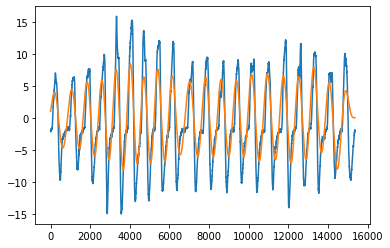

In [60]:
plt.figure()
plt.plot(rsp)
plt.plot(sigf)
plt.show()

In [64]:
rsp

array([-2.00504407, -2.05361794, -2.00091981, ..., -2.0762724 ,
       -2.06730549, -1.93133316])

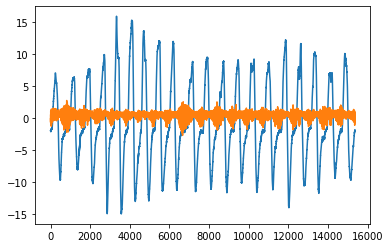

In [74]:
fs = 256
analytic_signal = signal.hilbert(rsp)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)

plt.figure()
plt.plot(rsp)
plt.plot(instantaneous_frequency)
plt.show()

In [100]:
def understand_hilbert(sig, fs):
    
    time = gh.time_vector(sig, fs)
    
    fs = 256
    analytic_signal = signal.hilbert(sig)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) / (2.0*np.pi) * fs)
    
    fig, axs = plt.subplots(nrows = 3, figsize = (16,10), constrained_layout = True)
    
    ax = axs[0]
    ax.plot(time, sig, label = 'raw')
    ax.plot(time, amplitude_envelope, label = 'amp evelope')
    ax.set_title('raw + envelope')
    
    ax = axs[1]
    ax.plot(time, instantaneous_phase)
    ax.set_title('instantaneous phase')
    
    ax = axs[2]
    ax.plot(time[:-1], instantaneous_frequency)
    ax.set_title(f'instantaneous frequency : mean = {round(np.mean(instantaneous_frequency), 2)}')
    
    plt.show()

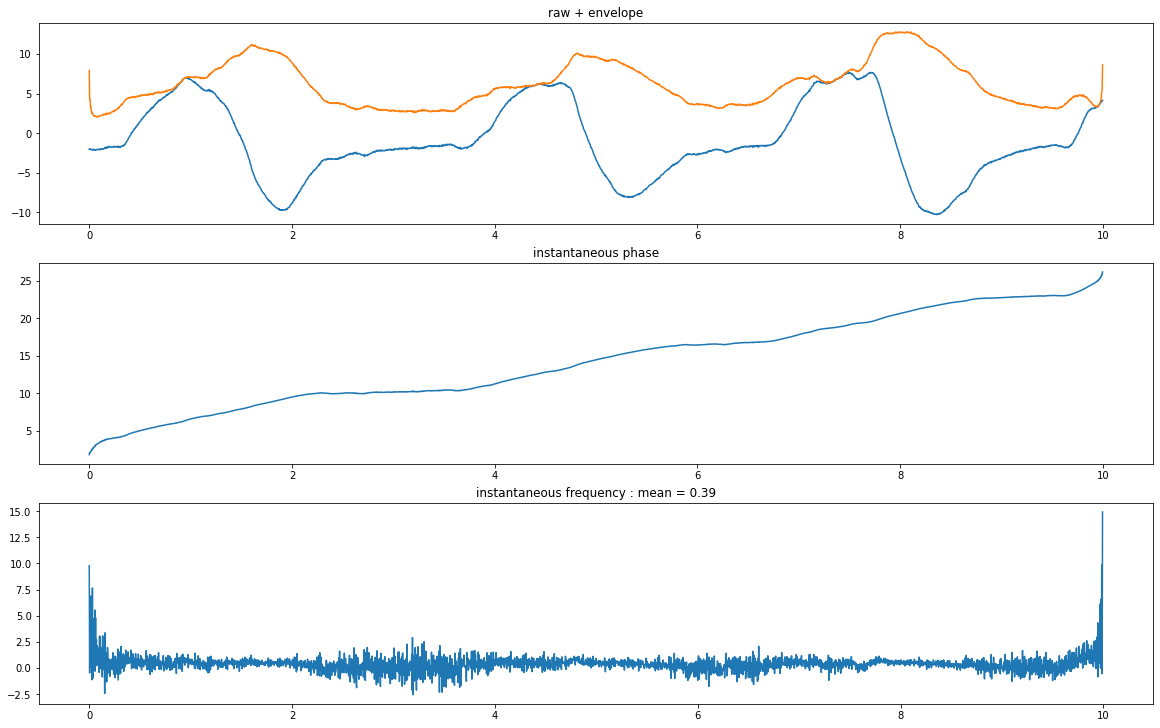

In [101]:
understand_hilbert(rsp[0:2560], fs=256)

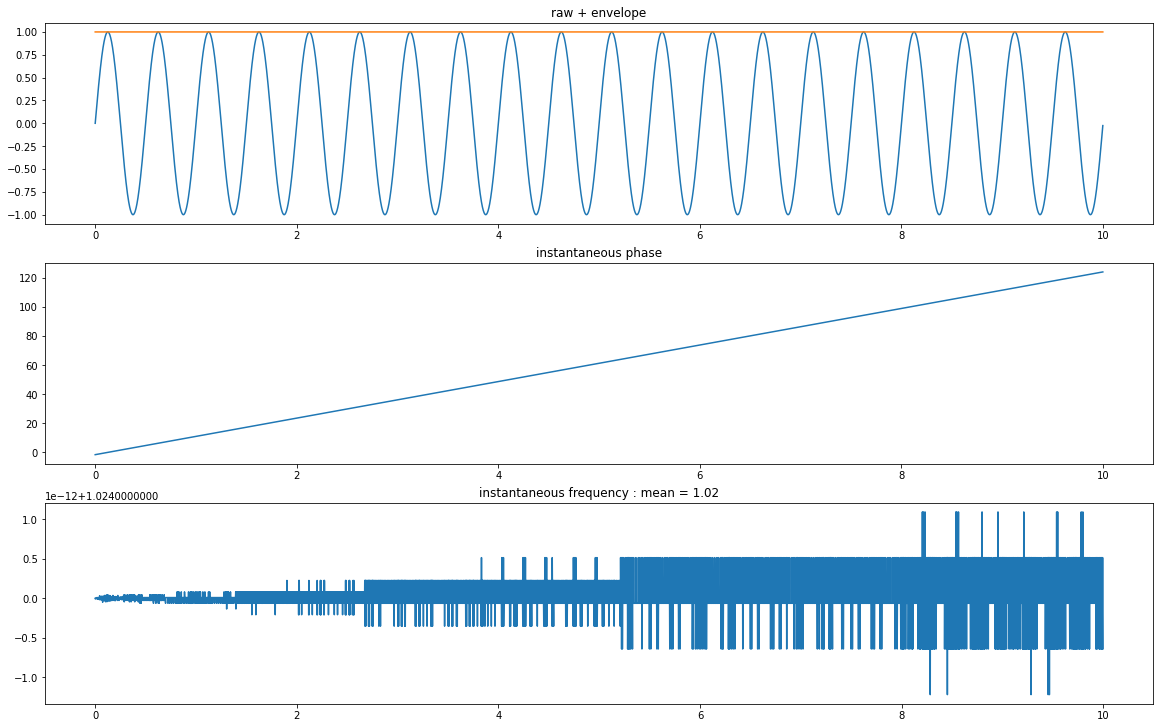

In [108]:
fs = 500
time = np.arange(0 , 10 , 1 / fs)
sig = np.sin(2 * np.pi * 2 * time)# + np.sin(2 * np.pi * 12 * time)
understand_hilbert(sig, fs=fs)